In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import Counter
import spacy
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_loc = "/content/drive/My Drive/Images"
caption_loc = "/content/drive/My Drive/captions.txt"

In [ ]:
df = pd.read_csv(caption_loc)
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
import string
translator = str.maketrans(',', '.', string.punctuation)
df['caption'] = df['caption'].apply(lambda x: x.translate(translator))
translator2 = str.maketrans('!','?', string.punctuation)
df['caption'] = df['caption'].apply(lambda x: x.translate(translator2))
df['caption'] = df['caption'].str.lower()
df

,image,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,a man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,a rock climber in a red shirt


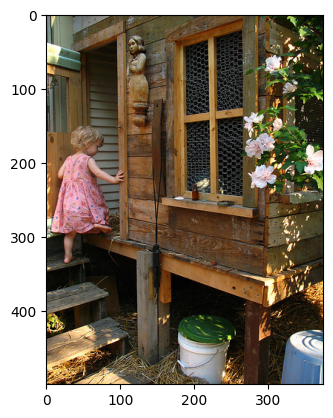

caption: a child in a pink dress is climbing up a set of stairs in an entry way 
caption: a girl going into a wooden building 
caption: a little girl climbing into a wooden playhouse 
caption: a little girl climbing the stairs to her playhouse 
caption: a little girl in a pink dress going into a wooden cabin 


In [ ]:
didx = 0
image_loca = image_loc + "/" + df.iloc[didx,0]
img = mpimg.imread(image_loca)
plt.imshow(img)
plt.show()
for i in range(didx, didx+5):
    print(f"caption: {df.iloc[i,1]}")

In [ ]:
spacy_eng = spacy.load('en_core_web_sm')

In [ ]:
class vocabprepros:
    def __init__(self,threshold_freq):
        self.threshold_freq = threshold_freq
        self.prc = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.prc.items()}

    def __len__(self):
        return len(self.prc)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def make_vocab(self,listsentence):
        frequencies = Counter()
        ix = 4
        for s in listsentence:
            for w in self.tokenize(s):
                frequencies[w] += 1

                if frequencies[w] == self.threshold_freq:
                    self.stoi[w] = ix
                    self.prc[ix] = w
                    ix += 1

    def numericaling(self,text):
        toknz_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in toknz_text]

In [ ]:
df2 = pd.read_csv(caption_loc)

In [ ]:
class PreprocessingDataset(Dataset):
    def __init__(self,root_dir,captionf,transform=None, threshold_freq=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captionf)
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = vocabprepros(threshold_freq)
        self.vocab.make_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]

        img_loc = os.path.join(self.root_dir,img_name)
        img = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericaling(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)



In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
# testing the dataset
dataset = PreprocessingDataset(
        root_dir = image_loc,
        captionf = caption_loc,
        transform = transforms
)

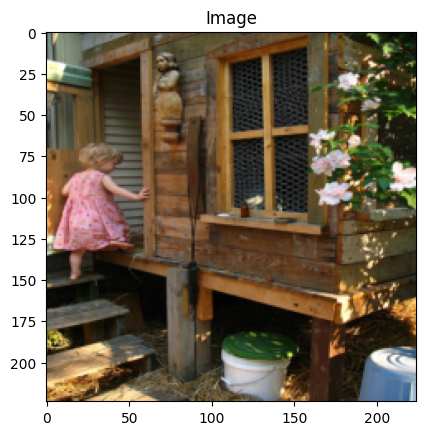

Token : tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [ ]:
img, caps = dataset[0]
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([dataset.vocab.prc[token] for token in caps.tolist()])

In [ ]:
class Paddingprepare:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx=pad_idx
        self.batch_first=batch_first
    def __call__(self,batch):
        imgs=[item[0].unsqueeze(0) for item in batch]
        imgs=torch.cat(imgs,dim=0)
        targts=[item[1] for item in batch]
        targts=pad_sequence(targts, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targts

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
train_size=int(0.8 * len(dataset))
test_size=len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
BATCH_SIZE=4
NUM_WORKER=1
pad_idx = dataset.vocab.stoi["<PAD>"]
# Create data loaders for the training and testing sets
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKER,
                          shuffle=True,
                          collate_fn=Paddingprepare(pad_idx=pad_idx,batch_first=True))
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKER,
                         shuffle=True,
                         collate_fn=Paddingprepare(pad_idx=pad_idx,batch_first=True))

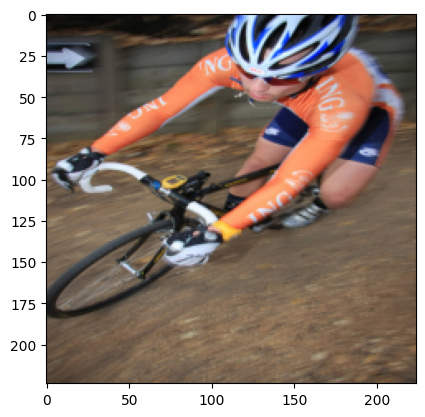

caption:  the biker is wearing a helmet .

------------------------------------------------------------------------------------------



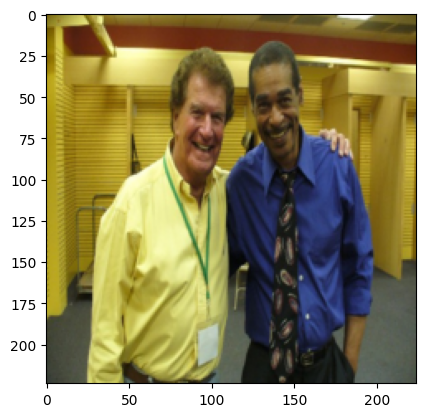

caption:  two guys , one black and one white , smiling for the camera .

------------------------------------------------------------------------------------------



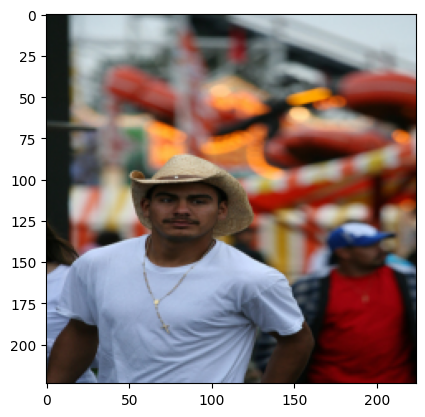

caption:  a man in a hat , white shirt and gold chain with a cross .

------------------------------------------------------------------------------------------



In [ ]:
dataiter = iter(train_loader)
batch = next(dataiter)

images, captions = batch

for i in range(0,3):
    img,cap=images[i],captions[i]
    captionImg=[dataset.vocab.prc[token] for token in cap.tolist()]
    eos_index=captionImg.index('<EOS>')
    captionImg=captionImg[1:eos_index]
    captionImg=' '.join(captionImg)
    show_image(img)
    print("caption: ",captionImg)
    print('\n------------------------------------------------------------------------------------------\n')
    plt.show()

In [ ]:
class EncoderRes(nn.Module):
    def __init__(self,embed_size):
        super(EncoderRes,self).__init__()
        resnet = models.resnet18(pretrained=True)
        #for param in resnet.parameters():
            #param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)
    def forward(self,images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

class Decoderlstm(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(Decoderlstm,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.lstm=nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn=nn.Linear(hidden_size,vocab_size)
        self.drop=nn.Dropout(drop_prob)
    def forward(self,features, captions):
        embeds = self.embedding(captions[:,:-1])
        x=torch.cat((features.unsqueeze(1),embeds),dim=1)
        x,_=self.lstm(x)
        x=self.fcn(x)
        return x

    def caption_produce(self,inputs,hidden=None,max_len=20,vocab=None):
        batch_size = inputs.size(0)
        captions = []
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab.prc[predicted_word_idx.item()] == "<EOS>":
                break
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        return [vocab.prc[idx] for idx in captions]


class EncoderR_DecoderL(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderR_DecoderL,self).__init__()
        self.encoder = EncoderRes(embed_size)
        self.decoder = Decoderlstm(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    def forward(self, images, captions):
        features=self.encoder(images)
        outputs=self.decoder(features, captions)
        return outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# initialize model and hyperparameters
embedingsize=300
hiddenlayersize=256
vocabsize=len(dataset.vocab)
numberlayers=1 #2
learning_rate=0.0001
num_epochs=1
model=EncoderR_DecoderL(embedingsize, hiddenlayersize, vocabsize, numberlayers).to(device)
lossfunc=nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer=optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
num_epochs = 10

los=[]
tlos=[]
train_loss=0
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)
        optimizer.zero_grad()
        outputs = model(image, captions)
        loss = lossfunc(outputs.view(-1, vocabsize), captions.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataset)
    tlos.append(train_loss)


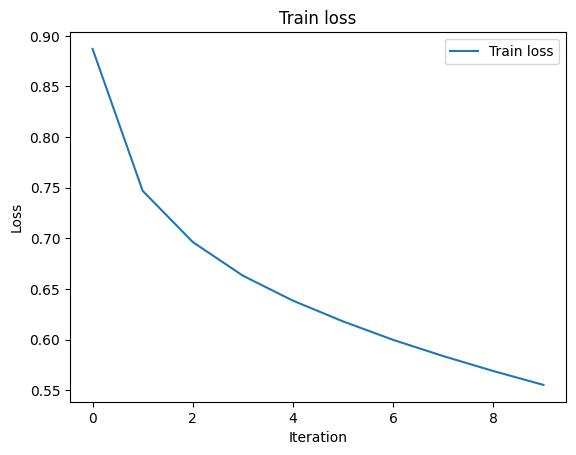

In [ ]:
plt.plot(tlos, label='Train loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
plt.show()

Epoch: 10 loss: 2.817
features shape - torch.Size([1, 300])


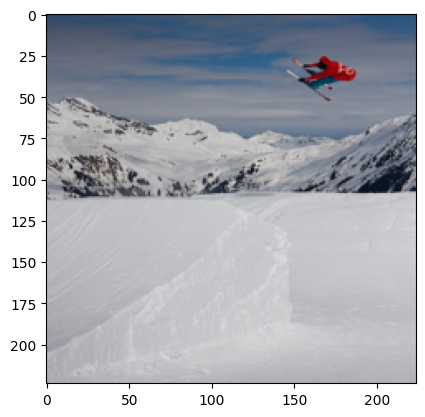

caption =  <SOS> a man is standing on a rock overlooking a lake . <EOS>

------------------------------------------------------------------------------------------

Epoch: 10 loss: 3.051
features shape - torch.Size([1, 300])


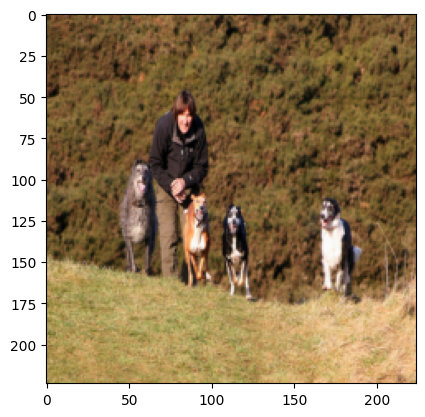

caption =  <SOS> two men are playing in a field . <EOS>

------------------------------------------------------------------------------------------

Epoch: 10 loss: 2.677
features shape - torch.Size([1, 300])


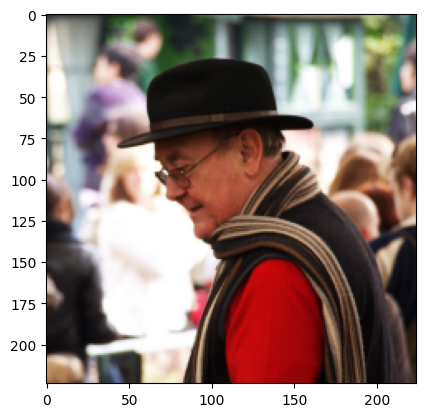

caption =  <SOS> a man in a black shirt is standing in front of a crowd . <EOS>

------------------------------------------------------------------------------------------



In [ ]:
testlos=[]

print_every = 2500
test_loss=0
for epoch in range(1,num_epochs+1):
  model.eval()
  with torch.no_grad():
    for idx, (image, captions) in enumerate(iter(test_loader)):
      image,captions = image.to(device),captions.to(device)
      outputs = model(image, captions)
      loss = lossfunc(outputs.view(-1, vocabsize), captions.view(-1))
      test_loss += loss.item()
      #
      if epoch == 10 and (idx == 500 or idx == 1000 or idx == 1500):
          print("Epoch: {} loss: {:.3f}".format(epoch,loss.item()))
          dataiter = iter(test_loader)
          img,_ = next(dataiter)
          features = model.encoder(img[0:1].to(device))
          print(f"features shape - {features.shape}")
          caps = model.decoder.caption_produce(features.unsqueeze(0),vocab=dataset.vocab)
          caption = ' '.join(caps)

          show_image(img[0])
          print("caption = ",caption)
          print('\n------------------------------------------------------------------------------------------\n')

      #
    test_loss /= len(test_loader)
    testlos.append(test_loss)

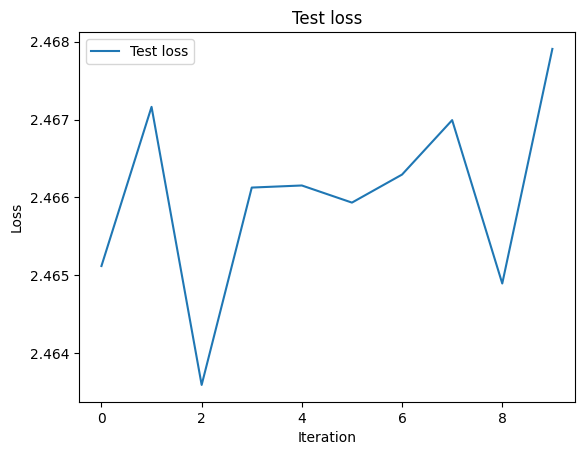

In [ ]:
plt.plot(testlos, label='Test loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Test loss')
plt.legend()
plt.show()

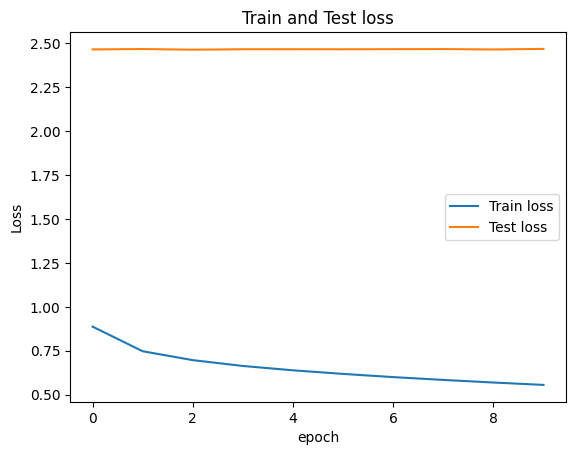

In [ ]:
plt.plot(tlos, label='Train loss')
plt.plot(testlos, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Train and Test loss')
plt.legend()
plt.show()

In [ ]:
#---------------------------------------------------------------------------------------------------------